# `flarestack` Test Minimization Notebook

## 1. Directory Setup

In [1]:
import logging
logging.basicConfig(level='INFO')

In [2]:
import os
os.environ['FLARESTACK_SCRATCH_DIR']

'/Users/thomasahrens/Desktop/IceCube/flarestack/scratch'

In [3]:
from flarestack.shared import host_server
from flarestack.data.icecube.ic_season import icecube_dataset_dir
print(f'Running at {host_server}, data directory is {icecube_dataset_dir}')

INFO:flarestack.shared:Scratch Directory is: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/input/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/cluster/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/input/pull_corrections/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/cluster/logs/
INFO:flarestack.shared:Fou

Running at None, data directory is /Users/thomasahrens/Desktop/IceCube/flarestack/datasets


In [4]:
from flarestack.shared import fs_scratch_dir
print(f'Scratch directory is {fs_scratch_dir}')

Scratch directory is /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/


## 2. Flarestack Classes

Classes used in $\texttt{flarestack}$'s core functionality (e.g. `flarestack.core.energy_pdf.EnergyPDF`, `flarestack.core.minimisation.MinimisationHandler`, etc) have a class attribute `<class>.subclasses`.  
This is a dictionary with the structure `{<subclass name>: <subclass>}`.  

In [5]:
from flarestack.core.minimisation import MinimisationHandler
MinimisationHandler.subclasses

{'fixed_weights': flarestack.core.minimisation.FixedWeightMinimisationHandler,
 'large_catalogue': flarestack.core.minimisation.LargeCatalogueMinimisationHandler,
 'fit_weights': flarestack.core.minimisation.FitWeightMinimisationHandler,
 'fit_weights_mcmc': flarestack.core.minimisation.FitWeightMCMCMinimisationHandler,
 'flare': flarestack.core.minimisation.FlareMinimisationHandler}

For analyses we only have to pass a dictionary of the subclass names and corresponding parameters.  
To execute use `flarestack.cluster.submitter.Submitter`. This always works locally. For using the cluster, again, if you are running at DESY or WIPAC, you do not have to worry. We got you covered.

In [6]:
from flarestack.cluster.submitter import Submitter
Submitter.submitter_dict

{'local': flarestack.cluster.submitter.LocalSubmitter,
 'DESY': flarestack.cluster.submitter.DESYSubmitter,
 'WIPAC': flarestack.cluster.submitter.WIPACSubmitter}

## 3. Example: Point Source Sensitivity

Let's try to calculate the 10-year point source sensitivity for one declination.  
First we have to specify a name for the analysis.

In [7]:
# Change gamma, minimizer, run number
name = "analyses/2source_gamma_2.2_mcmc_run1"

The input directory (with the analysis dictionaries), the output directory (plots, p-values, etc) and the cache directory (saved trials, etc) will be created accordingly.   
For example our plot output directory will be:

In [8]:
from flarestack.shared import plot_output_dir, name_pickle_output_dir
plot_output_dir(name), name_pickle_output_dir(name)

('/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.2_mcmc_run1',
 '/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/2source_gamma_2.2_mcmc_run1')

Many dataset implementations are available in `flarestack.data`. We will use the PS Tracks v3.2

In [9]:
# from flarestack.data.icecube import ps_v003_p02
from flarestack.data.public import icecube_ps_3_year

We want to inject a steady neutrino signal with a power law spectrum with $\gamma=2.5$. For other Energy or Time PDFs check `flarestack.core.energy_pdf` and `flarestack.core.time_pdf`.   \
This is as straight forward as:

In [10]:
injection_energy = {
    "energy_pdf_name": "power_law",
    "gamma": 2.2
}

injection_time = {
    "time_pdf_name": "steady"
}

inj_kwargs = {
    "injection_energy_pdf": injection_energy,
    "injection_sig_time_pdf": injection_time
}

We are looking for a steady signal with a power law spectrum. 
We assume the background to be constant in time.  
We want to use the "standard" point source likelihood. More likelihood implementations in `flarestack.core.llh`

In [11]:
llh_time = {
    "time_pdf_name": "steady"
}

llh_energy = {
    "energy_pdf_name": "power_law",
}

llh_time_bkg = {
    "time_pdf_name": "steady"
}

llh_kwargs = {
    "llh_name": "standard",
    "llh_energy_pdf": llh_energy,
    "llh_sig_time_pdf": llh_time,
    "llh_bkg_time_pdf": llh_time_bkg
}

We need a source catalogue. This catalogue will be a numpy array stored as a `.npy` file and we only pass the filename.   
For point sources the is a uitility function to generate dummy sources.

In [12]:
# from flarestack.utils.prepare_catalogue import ps_catalogue_name
import numpy as np

sindec = 0.5
catalogue_path = "/Users/thomasahrens/Desktop/IceCube/sn-search/test_catalogue_2.npy"
print(f'your catalogue is located at {catalogue_path}')
catalog = np.load(catalogue_path)
catalog

your catalogue is located at /Users/thomasahrens/Desktop/IceCube/sn-search/test_catalogue_2.npy


array([(0.19872028, -0.24886844, 1., 1., nan, nan, nan, 2.04324986e+13, b'ASASSN-14il'),
       (3.67889954, -0.67152028, 1., 1., nan, nan, nan, 1.64885347e+13, b'ASASSN-15ab')],
      dtype=[('ra_rad', '<f8'), ('dec_rad', '<f8'), ('base_weight', '<f8'), ('injection_weight_modifier', '<f8'), ('ref_time_mjd', '<f8'), ('start_time_mjd', '<f8'), ('end_time_mjd', '<f8'), ('distance_mpc', '<f8'), ('source_name', 'S30')])

Now we make a guess for our sensitivity.   
Note: $\texttt{flarestack}$ is using its own scale factor $k$

In [13]:
from flarestack.shared import flux_to_k
flux_to_k(1)

999999999.9999999

Here we know where the sensitivity should be. Because the analysis has been done before.

In [14]:
logging.basicConfig(level='ERROR')
from flarestack.icecube_utils.reference_sensitivity import reference_sensitivity
scale = flux_to_k(reference_sensitivity(np.sin(catalog['dec_rad']))) * 3
scale

array([ 6.24859081, 24.92108471])

Now we just have to put all the info into one dictionary to pass to the `MinimisationHandler`

In [15]:
mh_dict = {
    "name": name,                                           # unique name for the analysis
    "mh_name": "fit_weights_mcmc",                          # name of the MinimisationHandler subcalss
    "dataset": icecube_ps_3_year.get_seasons("IC86-2012"),  # the neutrino dataset
    "catalogue": catalogue_path,                            # path to the .npy catalogue file
    "inj_dict": inj_kwargs,                                 # info for the Injector
    "llh_dict": llh_kwargs,                                 # info for the LLH
    "scale": 1000,                                          # a guess for the sensitivity scale
    "n_walkers": 10,                                        # number of MCMC walkers
    "walker_steps": 2000,                                   # number of MCMC steps
    "n_trials": 10,                                         # number of trials to run (background trials will be run ten times this number!)
    "n_steps": 10,                                          # number of steps when injecting signal
    "allow_extrapolated_sensitivity": True                  # allow extrapolation in the sensitivity calculation (here we do because we only run very few trials)
}

To execute the analysis we defined above we create a submitter instance

In [16]:
submitter = Submitter.get_submitter(
    mh_dict=mh_dict,                         # the analysis info
    use_cluster=False,                       # run it on the cluster if True
    n_cpu=10,                                 # number of LOCAL CPUs to use, NOTE: the number of cluster CPUs has to be specified in the cluster_kwargs!
    do_sensitivity_scale_estimation=False,   # make a guess of the sensitivity scale, for options check flarestack.cluster.submitter
    remove_old_results=True,                 # if you are running the analysis again and something changed, maybe you want to remove old trials?
#   **cluster_kwargs                         # keyword arguments used when running the cluster, This depends on the cluster obviously
)

print(submitter)


----- Submitter for analyses/2source_gamma_2.2_mcmc_run1 -----
not using cluster 
using 10 CPUs locally
job-id: None 
no scale estimation 



Energise ......

In [17]:
submitter.analyse()

INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.injector:Initialising Injector for IC86-2012
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.multiprocess_wrapper:Added 190 trials to queue. Now processing.
INFO:flarestack.core.multiprocess_wrapper:190 tasks remaining.
INFO:flarestack.core.minimisation:Using 'standard' LLH class
/Users/thomasahrens/Desktop/IceCube/flarestack/flarestack/core/llh.py:912: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple

To get the results we use the `ResultsHandler`. This will also create some plots like the sensitivity fit, bias plots, etc. in the plot directory.

In [20]:
from flarestack.core.results import ResultsHandler
results_handler = ResultsHandler(submitter.mh_dict)

INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.2_mcmc_run1/bias_n_s (b'ASASSN-15ab').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.2_mcmc_run1/bias_n_s (b'ASASSN-14il').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.2_mcmc_run1/bias_gamma.pdf
INFO:flarestack.core.results:Fraction of overfluctuations is 0.50 above -0.69 (N_trials=100) (Scale=0)
INFO:flarestack.core.results:Fraction of overfluctuations is 0.90 above -0.69 (N_trials=10) (Scale=111.1)
INFO:flarestack.core.results:Fraction of overfluctuations is 1.00 above -0.69 (N_trials=10) (Scale=222.2)
INFO:flarestack.core.results:Fraction of overfluctuations is 0.90 above -0.69 (N_trials=10) (Scal

In [21]:
print(fr'sensitivity flux: {results_handler.sensitivity:.2e} +{results_handler.sensitivity_err[1]}  -{results_handler.sensitivity_err[0]}')
print(f'reference: {reference_sensitivity(sindec)[0]}')
print(fr'sensitivity n_s: {results_handler.sensitivity * results_handler.flux_to_ns:.2e} +{results_handler.sensitivity_err[1] * results_handler.flux_to_ns}  -{results_handler.sensitivity_err[0] * results_handler.flux_to_ns}')

sensitivity flux: 1.13e-07 +-2.589286629088461e-07  -7.263567936021694e-08
reference: 5.770894709671131e-10
sensitivity n_s: 1.06e+00 +-2.4214025923377496  -0.6792613082042608


In [22]:
results_handler.__dict__

{'sources': array([(3.67889954, -0.67152028, 1., 1., nan, nan, nan, 1.64885347e+13, b'ASASSN-15ab'),
        (0.19872028, -0.24886844, 1., 1., nan, nan, nan, 2.04324986e+13, b'ASASSN-14il')],
       dtype=[('ra_rad', '<f8'), ('dec_rad', '<f8'), ('base_weight', '<f8'), ('injection_weight_modifier', '<f8'), ('ref_time_mjd', '<f8'), ('start_time_mjd', '<f8'), ('end_time_mjd', '<f8'), ('distance_mpc', '<f8'), ('source_name', 'S30')]),
 'name': 'analyses/2source_gamma_2.2_mcmc_run1/',
 'mh_name': 'fit_weights_mcmc',
 'scale': 1000,
 'results': {'444.4': {'TS': [24.140132471943758,
    19.896573589624868,
    12.874342714549847,
    11.83018316558652,
    14.695254239312156,
    11.930746728089579,
    3.466080449231163,
    -0.5611194103070054,
    18.117985313862846,
    9.973380777321164],
   'Parameters': {"n_s (b'ASASSN-15ab')": [1.2230417113783467,
     3.427346608530306,
     0.964819640654978,
     3.912201788549413,
     1.03703907187246,
     1.2515750355605766,
     1.296324400924

## 4. MCMC Analysis Plots

### Corner Plot

In [30]:
import pickle

# Path to MCMC pickle directory
import pickle
# mcmc_pickle_path = '/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/chains_walkmove.pkl'
mcmc_pickle_path = os.path.join(name_pickle_output_dir(name), 'chains.pkl')

with open(mcmc_pickle_path, 'rb') as file:
    mcmc_pickle = pickle.load(file)
    
mcmc_pickle.shape

(2000, 10, 3)

In [31]:
# Number of dimensions
ndim = len(catalog) + 1

# Reshape MCMC chains
mcmc_chains = mcmc_pickle[:,...].reshape((-1,ndim))

mcmc_chains.shape

(20000, 3)

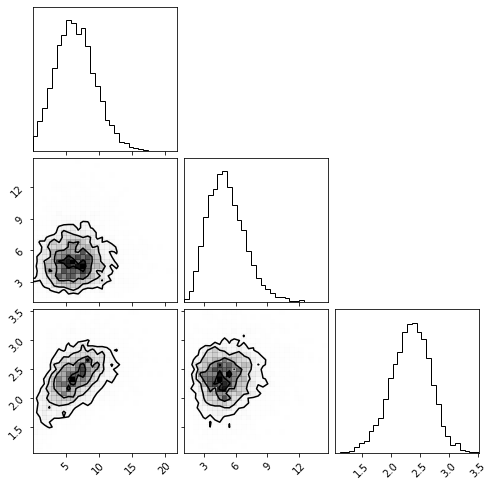

In [32]:
from corner import corner

# Create corner plots showing burn in time for MCMC flarestack simulation chains
fig = corner(mcmc_chains,
#             labels=[r'$\tau$', r'$\kappa$', '$V_s$', r'$\epsilon$', r'$\omega$', r'$\chi$', '$b$'],
#             levels=[1-np.exp(-0.5*(x**2)) for x in range(1,4)],
#             range=[[1100,1350], [50,200], [-20,20], [0.4,0.9], [1.7*np.pi,2*np.pi], [0.12,0.32], [0.5,1.5]],
#             truths = [1, 1, injection_energy['gamma']],
            plot_datapoints=False,
            bins=30)

### Walker Steps

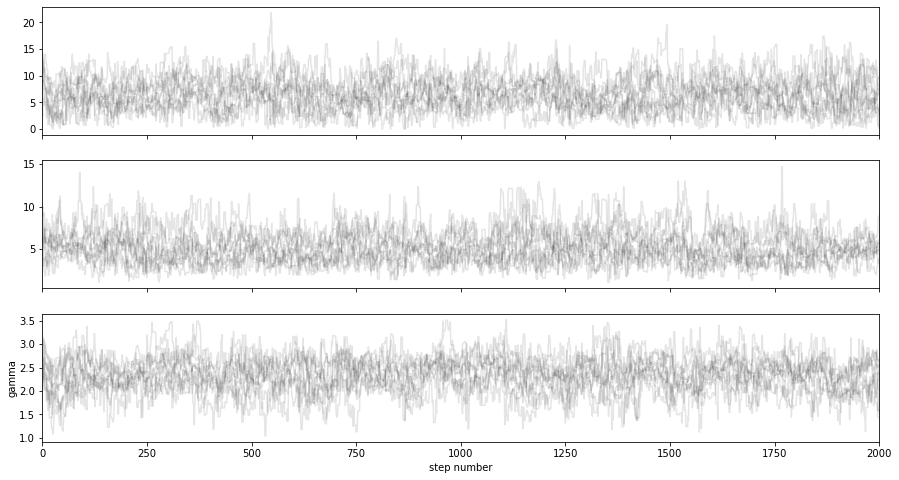

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, figsize=(15, 8), sharex=True)
# samples = sampler.get_chain()
labels = ["", "", 'gamma']
for i in range(ndim):
    ax = axes[i]
    ax.plot(mcmc_pickle[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(mcmc_pickle))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.03, 0.5)

axes[-1].set_xlabel("step number");

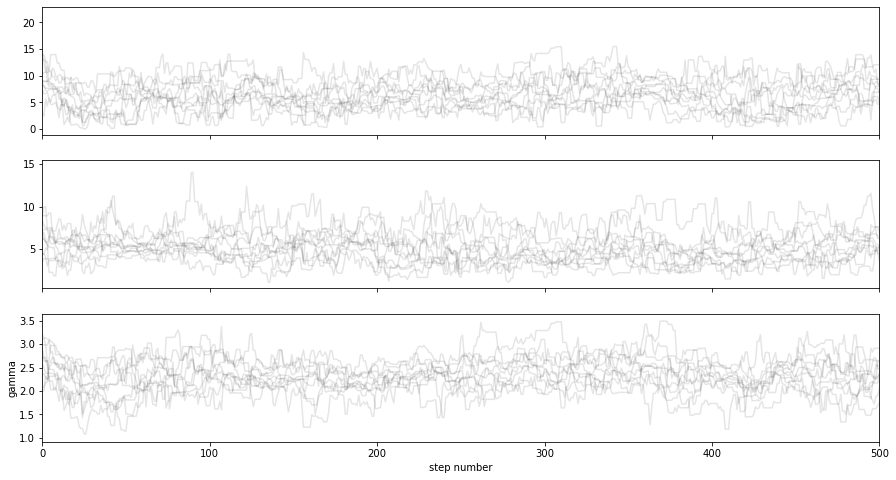

In [34]:
# First 500 steps
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, figsize=(15, 8), sharex=True)
# samples = sampler.get_chain()
labels = ["", "", 'gamma']
for i in range(ndim):
    ax = axes[i]
    ax.plot(mcmc_pickle[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(mcmc_pickle[:500]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.03, 0.5)

axes[-1].set_xlabel("step number");